# 学習方法の例

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from common.layers import TwoLayerNet
from sklearn.model_selection import train_test_split
import pickle

In [2]:
import mlflow
import mlflow.sklearn

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle

try:
    from google.colab import files
    print('Google Colab. 上での実行です')
    print('「ファイルを選択」から、2_notebook/commonのlayers.pyを選択し、アップロードしてください')
    print('===========')
    files.upload()
    !mkdir common
    !mv *.py ./common
    print('次に 1_dataのtrain_data.npy、train_label.npyを選択し、アップロードしてください')
    print('===========')
    files.upload()
    !mkdir ../1_data
    !mv *.npy ../1_data
except:
    print('ローカル環境での実行です')


from common.layers import TwoLayerNet

ローカル環境での実行です


## データを読む1

In [47]:
train_data = np.load("../1_data/train_data.npy")
train_label = np.load("../1_data/train_label.npy")
print("train_data.shape=", train_data.shape)
print("train_label.shape=", train_label.shape)

train_data.shape= (3000, 1, 28, 28)
train_label.shape= (3000, 15)


In [48]:
# 正規化
train_data = (train_data - train_data.min()) / train_data.max()
train_data = train_data.astype('float32')
# print(train_data)

In [49]:
# 配列形式変更
train_data = train_data.reshape(-1, 28*28)
print("train_data.shape=", train_data.shape)

train_data.shape= (3000, 784)


## trainとtestに分割する

In [50]:
X_train_all, X_test, y_train_all, y_test = train_test_split(train_data, train_label, 
                                                    test_size=0.3, random_state=1234,
                                                    shuffle=True
                                                   )

print(X_train_all.shape, X_test.shape)

(2100, 784) (900, 784)


In [51]:
# データを間引く
# X_train = X_train_all[:1000,:]
# y_train = y_train_all[:1000,:]
X_train = X_train_all
y_train = y_train_all
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(2100, 784) (900, 784)
(2100, 15) (900, 15)


## 学習

In [77]:

# epochs = 10#200
# batch_size = 16#32
# lr = 0.01
experiment_id = 2
def model_train(epochs, batch_size, lr):
    # 繰り返し回数
    xsize = X_train.shape[0]
    iter_num = np.ceil(xsize / batch_size).astype(np.int)

    # 2層NNのオブジェクト生成
    tnet = TwoLayerNet(input_size=28*28, hidden_size=10, output_size=15)

    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    
    with mlflow.start_run(experiment_id=experiment_id):

        for epoch in range(epochs):
            if np.mod(epoch,10)==0 : print("**epoch=%s"%epoch)

            # シャッフル
            idx = np.arange(xsize)
            np.random.shuffle(idx)

            for it in range(iter_num):
                """
                ランダムなミニバッチを順番に取り出す
                """
                mask = idx[batch_size*it : batch_size*(it+1)]

                # ミニバッチの生成
                x_ = X_train[mask]
                y_ = y_train[mask]

                # 勾配の計算
                grads = tnet.gradient(x_, y_)

        #         # 勾配の比較（通常はコメントアウト）
        #         # diffの値がほぼゼロであれば誤差逆伝播法が正しく実装できている
        #         grad_numerical = tnet.numerical_gradient(x_, y_)
        #         for key in grad_numerical.keys():
        #             diff = np.average(np.abs(grads[key] - grad_numerical[key]))
        #             print(key + ":" + str(diff))

        #         break    

                # パラメータの更新
                for key in tnet.params.keys():
            #         print(key)
                    tnet.params[key] -= lr * grads[key]

            ## 学習経過の記録

            # 訓練データにおけるloss
            train_loss.append(tnet.loss(X_train,  y_train))

            # テストデータにおけるloss
            test_loss.append(tnet.loss(X_test, y_test))

            # 訓練データにて精度を確認
            train_accuracy.append(tnet.accuracy(X_train, y_train))

            # テストデータにて精度を算出
            test_accuracy.append(tnet.accuracy(X_test, y_test))
            
                    # 追加箇所
        # ハイパーパラメータ, 評価指標, 学習済みモデルをMLflowへ保存
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("lr", lr)
        mlflow.log_metric("train_accuracy", train_accuracy[-1])
        mlflow.log_metric("test_accuracy", test_accuracy[-1])

        mlflow.sklearn.log_model(tnet, "model")

        
    return tnet, train_accuracy, test_accuracy

In [78]:
epochs = 40 #200
batch_size = 16#32
lr = 0.01

tnet, train_accuracy, test_accuracy = model_train(epochs, batch_size, lr)
print(test_accuracy[-1])
print(train_accuracy[-1])
print(test_accuracy)

/tmp/ipykernel_710/659576625.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iter_num = np.ceil(xsize / batch_size).astype(np.int)


**epoch=0
**epoch=10
**epoch=20
**epoch=30
0.8588888888888889
0.9057142857142857
[0.1322222222222222, 0.07111111111111111, 0.10444444444444445, 0.17888888888888888, 0.26666666666666666, 0.40444444444444444, 0.4222222222222222, 0.46111111111111114, 0.4411111111111111, 0.5477777777777778, 0.6311111111111111, 0.6188888888888889, 0.71, 0.7344444444444445, 0.6711111111111111, 0.7077777777777777, 0.7366666666666667, 0.6888888888888889, 0.8022222222222222, 0.7788888888888889, 0.78, 0.7522222222222222, 0.8111111111111111, 0.8255555555555556, 0.7177777777777777, 0.8388888888888889, 0.8411111111111111, 0.7455555555555555, 0.8088888888888889, 0.8166666666666667, 0.7911111111111111, 0.8277777777777777, 0.8344444444444444, 0.8488888888888889, 0.8411111111111111, 0.7511111111111111, 0.8455555555555555, 0.7677777777777778, 0.8077777777777778, 0.8588888888888889]


In [73]:
# 管理IDを発行（コードの実行に対して）
experiment_id = 1
with mlflow.start_run(experiment_id=experiment_id):
    # ハイパーパラメータの試行水準
    cand_batch_size = [16, 32, 48]
    cand_lr = [0.005, 0.01, 0.02]

    trial = 0
    for batch_size in cand_batch_size:
        for lr in cand_lr:
            # 管理IDを発行（各パラメータ水準に対して）
            with mlflow.start_run(experiment_id=experiment_id, nested=True):
                trial += 1
                tnet, train_accuracy, test_accuracy = model_train(epochs, batch_size, lr)
                # model, mse, R2 = train(n_estimators, max_depth)
                # 小数点以下３桁まで出力
                print(f"trial {trial}: batch_size={batch_size}, lr={lr}, \
                      train_accuracy={train_accuracy[-1]:.3}, test_accuracy={test_accuracy[-1]:.3}")
                # 追加箇所
                # ハイパーパラメータ, 評価指標, 学習済みモデルをMLflowへ保存
                mlflow.log_param("batch_size", batch_size)
                mlflow.log_param("lr", lr)
                mlflow.log_metric("train_accuracy", train_accuracy[-1])
                mlflow.log_metric("test_accuracy", test_accuracy[-1])

                mlflow.sklearn.log_model(tnet, "model")


/tmp/ipykernel_710/3537043291.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iter_num = np.ceil(xsize / batch_size).astype(np.int)


**epoch=0
**epoch=10
**epoch=20
**epoch=30
trial 1: batch_size=16, lr=0.005,                       train_accuracy=0.805, test_accuracy=0.782
**epoch=0
**epoch=10
**epoch=20
**epoch=30
trial 2: batch_size=16, lr=0.01,                       train_accuracy=0.906, test_accuracy=0.848
**epoch=0
**epoch=10
**epoch=20
**epoch=30
trial 3: batch_size=16, lr=0.02,                       train_accuracy=0.754, test_accuracy=0.701
**epoch=0
**epoch=10
**epoch=20
**epoch=30
trial 4: batch_size=32, lr=0.005,                       train_accuracy=0.68, test_accuracy=0.653
**epoch=0
**epoch=10
**epoch=20
**epoch=30
trial 5: batch_size=32, lr=0.01,                       train_accuracy=0.81, test_accuracy=0.792
**epoch=0
**epoch=10
**epoch=20
**epoch=30
trial 6: batch_size=32, lr=0.02,                       train_accuracy=0.844, test_accuracy=0.792
**epoch=0
**epoch=10
**epoch=20
**epoch=30
trial 7: batch_size=48, lr=0.005,                       train_accuracy=0.294, test_accuracy=0.282
**epoch=0
**epoch=1

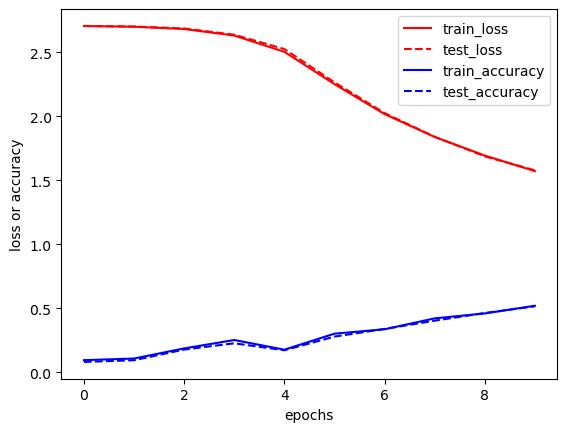

In [19]:
# lossのグラフ化
df_log = pd.DataFrame({"train_loss":train_loss,
             "test_loss":test_loss,
             "train_accuracy":train_accuracy,
             "test_accuracy":test_accuracy})
df_log.plot(style=['r-', 'r--', 'b-', 'b--'])
plt.ylabel("loss or accuracy")
plt.xlabel("epochs")
plt.show()

## 学習済みモデルの出力

In [16]:
with open("katakana_model.pickle", "wb") as f:
    pickle.dump(tnet, f)

- Google Colab. を使用している人は `katakana_model.pickle` のダウンロードを忘れないようにしよう
  - 「識別精度算出ウェブサイト」への投稿に必要な情報であるため
  - ファイルダウンロードの参考：https://blog.kikagaku.co.jp/google-colab-file#_Google_Colab